In [3]:
repo_path = 'D:\ProjGit\plinko\plinko_nn'

In [4]:
import os
import sys
sys.path.append(repo_path + '/src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.misc import plot as plinko_plot
from plinko.model.mlp import MLP
from plinko.model.relNet import relNet
from plinko.misc import utils

from plotnine import * #ggplot, geom_point, aes, labs
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

In [6]:
def createStates(df_ball, df_env, df_col,device):
    collisions = df_col.copy()
    collisions = collisions.rename({'object': 'collision'}, axis=1)
    collisions.t -= 1

    collisions = df_ball.merge(collisions, how='left')
    # collisions = collisions[~collisions.collision.isna()]
    collisions.collision[collisions.collision.isna()] = 'none'
    collisions.collision[(collisions.collision == 'walls') & (collisions.px < 200)] = 'left_wall'
    collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500)] = 'right_wall'
    collisions = collisions.groupby('collision', as_index=False).apply(lambda x: x.sample(2000))
    collisions = collisions.sort_values(['simulation', 'run', 't'])

    env_columns = ['triangle_x', 'triangle_y', 'triangle_r',
                   'rectangle_x', 'rectangle_y', 'rectangle_r',
                   'pentagon_x', 'pentagon_y', 'pentagon_r']
    envs = collisions.merge(df_env).sort_values(['simulation', 'run', 't'])[env_columns]

    idx2col = sorted(collisions.collision.unique())
    col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}

    states = torch.tensor(collisions[['px', 'py', 'vx', 'vy']].values, dtype=torch.float, device=device)
    targets = torch.tensor([col2idx[c] for c in collisions.collision], dtype=torch.long, device=device)
    envs = torch.tensor(envs.values, dtype=torch.float, device=device)

    return states,targets,envs, idx2col, col2idx

In [4]:
states,targets,envs, idx2col, col2idx = createStates(df_ball, df_env, df_col,device)

In [5]:
model = relNet(state_size = 4, state_hn = 4, state_embed_size=32,
                obj_size = 3, obj_hn = 4,obj_embed_size=16,
                obj_n = 3, nullobj_n = 4,
                mlp_hsize = 16, mlp_hn=3, mlp_outsize=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
epochs = 3000

rows = []
for epoch in tqdm(range(epochs + 1)):
    optimizer.zero_grad()
    outputs = model(envs, states)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()

    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    rows.append(row)
    if epoch % 50 == 0:
        print(epoch, round(loss, 4), round(accuracy, 4))
        
summary = pd.DataFrame(rows)

0 1.9464 0.1429
50 1.3395 0.5888
100 0.9098 0.6689
150 0.8066 0.7152
200 0.7541 0.7076
250 0.7041 0.7436
300 0.6681 0.7503
350 0.6399 0.7543
400 0.6192 0.7651
450 0.5718 0.7625
500 0.5419 0.7836
550 0.5112 0.7814
600 0.4914 0.7876
650 0.4735 0.7919
700 0.4507 0.7938
750 0.4432 0.7905
800 0.4291 0.8041
850 0.4154 0.8076
900 0.4452 0.8045
950 0.4047 0.8173
1000 0.3968 0.8162
1050 0.3927 0.8208
1100 0.4123 0.8018
1150 0.3884 0.8328
1200 0.3744 0.8424
1250 0.4007 0.8381
1300 0.3651 0.8571
1350 0.3547 0.8694
1400 0.3423 0.8768
1450 0.3319 0.8824
1500 0.4628 0.8546
1550 0.323 0.8962
1600 0.3035 0.9011
1650 0.288 0.9085
1700 0.2748 0.9136
1750 0.2642 0.9164
1800 0.2526 0.9234
1850 0.2383 0.9296
1900 0.2157 0.9363
1950 0.2067 0.9413
2000 0.1878 0.9434
2050 0.2167 0.9356
2100 0.1704 0.9501
2150 0.1614 0.9532
2200 0.1551 0.9563
2250 0.1534 0.9534
2300 0.1435 0.9589
2350 0.4875 0.8722
2400 0.2034 0.9482
2450 0.1749 0.953
2500 0.1617 0.9562
2550 0.1527 0.9589
2600 0.1484 0.958
2650 0.1416 0.9615
2

In [ ]:
torch.save(model.state_dict(), savename + '.model')

In [17]:
model.load_state_dict(torch.load(savename + '.model'))
model.eval()

relNet(
  (state_embdder): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (obj_embdder): ModuleList(
    (0): ModuleList(
      (0): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=3, out_features=16, bias=True)
          (1): Linear(in_features=16, out_features=16, bias=True)
          (2): Linear(in_features=16, out_features=16, bias=True)
          (3): Linear(in_features=16, out_features=16, bias=True)
          (4): Linear(in_features=16, out_features=16, bias=True)
        )
      )
    )
    (1): ModuleList(
      (0): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=3, out_features=16, bias=True)
          (1): Linear(in_features=16, out_

In [22]:
# train more 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
epochs2 = 3000

for epoch in tqdm(range(epochs2 + 1)):
    optimizer.zero_grad()
    outputs = model(envs, states)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()

    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch+epochs, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    rows.append(row)
    if epoch % 50 == 0:
        print(epoch+epochs, round(loss, 4), round(accuracy, 4))
        
summary = pd.DataFrame(rows)

3000 0.1215 0.9686
3050 0.2061 0.9479
3100 0.1377 0.9639
3150 0.1276 0.9659
3200 0.1222 0.9669
3250 0.1198 0.9682
3300 0.1177 0.969
3350 0.1142 0.9701
3400 0.1116 0.9706
3450 0.1098 0.9706
3500 0.1089 0.9713
3550 0.1055 0.9718
3600 0.1039 0.9719
3650 0.1025 0.9724
3700 0.1011 0.9724
3750 0.1001 0.9724
3800 0.1469 0.9626
3850 0.1704 0.9552
3900 0.1161 0.9699
3950 0.1079 0.9719
4000 0.0999 0.9717
4050 0.097 0.9731
4100 0.0953 0.9739
4150 0.0938 0.9742
4200 0.0925 0.9746
4250 0.0914 0.9751
4300 0.0904 0.9754
4350 0.0893 0.9756
4400 0.0882 0.9759
4450 0.0979 0.9704
4500 1.1634 0.81
4550 0.1279 0.9633
4600 0.1029 0.9719
4650 0.0955 0.9738
4700 0.0915 0.9751
4750 0.0891 0.9757
4800 0.0874 0.976
4850 0.0859 0.9764
4900 0.0846 0.9766
4950 0.0835 0.9769
5000 0.0824 0.9769
5050 0.0814 0.9769
5100 0.0808 0.9771
5150 0.0805 0.9768
5200 0.107 0.9712
5250 0.0818 0.9778
5300 0.0792 0.9781
5350 0.0778 0.9783
5400 0.0766 0.9782
5450 0.0822 0.9763
5500 0.1475 0.9641
5550 0.0843 0.9777
5600 0.0769 0.9786

In [24]:
# train even more with smaller learning rate.
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
epochs3 = 1000

for epoch in tqdm(range(epochs3 + 1)):
    optimizer.zero_grad()
    outputs = model(envs, states)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()

    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch+epochs+epochs2, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    rows.append(row)
    if epoch % 50 == 0:
        print(epoch+epochs+epochs2, round(loss, 4), round(accuracy, 4))
        
summary = pd.DataFrame(rows)

6000 0.0705 0.9796
6050 0.0703 0.9794
6100 0.07 0.9798
6150 0.0696 0.9799
6200 0.0691 0.98
6250 0.0686 0.9801
6300 0.068 0.9802
6350 0.0674 0.9802
6400 0.0668 0.9802
6450 0.0662 0.9804
6500 0.0656 0.9806
6550 0.065 0.9806
6600 0.0643 0.9806
6650 0.0637 0.9808
6700 0.0631 0.9808
6750 0.0625 0.9809
6800 0.062 0.9811
6850 0.0615 0.9814
6900 0.0609 0.9816
6950 0.0605 0.9818
7000 0.0601 0.982



In [25]:
# train even more with smaller learning rate.
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
epochs4 = 2000

for epoch in tqdm(range(epochs4 + 1)):
    optimizer.zero_grad()
    outputs = model(envs, states)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()

    loss = float(loss)
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch+epochs+epochs2+epochs3, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    rows.append(row)
    if epoch % 50 == 0:
        print(epoch+epochs+epochs2+epochs3, round(loss, 4), round(accuracy, 4))
        
summary = pd.DataFrame(rows)

7000 0.0601 0.9816
7050 0.0601 0.9816
7100 0.0599 0.9819
7150 0.0598 0.9818
7200 0.0597 0.9819
7250 0.0595 0.9819
7300 0.0594 0.982
7350 0.0592 0.982
7400 0.059 0.9821
7450 0.0588 0.9821
7500 0.0586 0.9821
7550 0.0583 0.9821
7600 0.0581 0.9821
7650 0.0578 0.9821
7700 0.0575 0.9823
7750 0.0572 0.9824
7800 0.057 0.9824
7850 0.0567 0.9825
7900 0.0564 0.9825
7950 0.0561 0.9826
8000 0.0558 0.9826
8050 0.0556 0.9826
8100 0.0553 0.9826
8150 0.055 0.9826
8200 0.0547 0.9828
8250 0.0544 0.9831
8300 0.0541 0.9829
8350 0.0538 0.9829
8400 0.0535 0.9831
8450 0.0535 0.9834
8500 0.053 0.9834
8550 0.0528 0.9834
8600 0.0526 0.9833
8650 0.0524 0.9835
8700 0.052 0.9836
8750 0.0518 0.9836
8800 0.0515 0.9837
8850 0.0543 0.9834
8900 0.0511 0.9842
8950 0.0509 0.9843
9000 0.0508 0.9843



In [28]:
savename = repo_path + '/experiments/collisions/relnet1'
torch.save(model.state_dict(), savename + '_9000epochs.model')
pd.DataFrame(summary).to_pickle(savename + '.pkl')

       epoch   collision  accuracy
3000    3000       total  0.968643
12003   3000      ground  0.992000
21006   3000   left_wall  0.998500
30009   3000        none  0.867000
39012   3000    pentagon  0.971000
48015   3000   rectangle  0.970500
57018   3000  right_wall  0.998000
66021   3000    triangle  0.983500


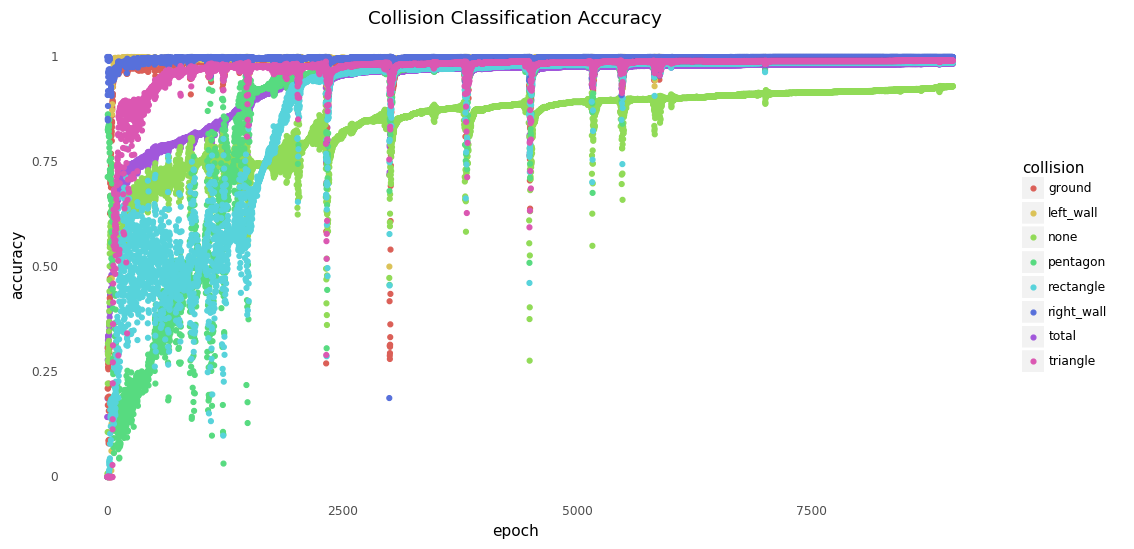

<ggplot: (155513296925)>


In [26]:
accuracies = summary.drop('loss', axis=1)
accuracies = pd.melt(accuracies, id_vars='epoch', var_name='collision')
accuracies.collision = [a[4:] for a in accuracies.collision]
accuracies = accuracies.rename({'value': 'accuracy'}, axis=1)
print(accuracies[accuracies['epoch']==epochs])

p = (ggplot(accuracies)
     + geom_point(aes(x='epoch', y='accuracy', color='collision'))
     + labs(title='Collision Classification Accuracy')
     + ylim(0, 1)
     + theme(
             figure_size=(12, 6),
             panel_background=element_blank(),
             line=element_blank(),
             panel_border=element_blank(),  
            )
)

print(p)

(7, 7)
['ground', 'left_wall', 'none', 'pentagon', 'rectangle', 'right_wall', 'triangle']
[[9.955e-01 5.000e-04 2.500e-03 0.000e+00 0.000e+00 1.500e-03 0.000e+00]
 [1.000e-03 9.990e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [3.800e-02 5.000e-04 9.300e-01 8.000e-03 7.500e-03 9.000e-03 7.000e-03]
 [9.500e-03 0.000e+00 1.000e-03 9.870e-01 1.000e-03 1.000e-03 5.000e-04]
 [4.000e-03 0.000e+00 5.500e-03 0.000e+00 9.870e-01 3.500e-03 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [6.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.500e-03 9.915e-01]]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

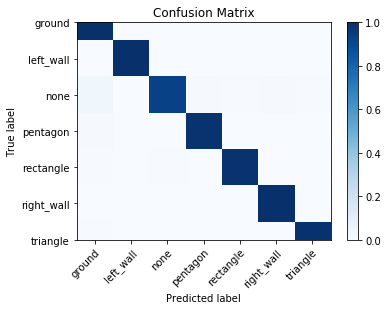

In [27]:
cm = confusion_matrix(targets.cpu(), outputs.argmax(-1).cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize
classes = idx2col
print(classes)

print(cm)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

['ground', 'left_wall', 'none', 'pentagon', 'rectangle', 'right_wall', 'triangle']
[[9.865e-01 1.500e-03 6.000e-03 0.000e+00 0.000e+00 6.000e-03 0.000e+00]
 [1.500e-03 9.975e-01 1.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [5.100e-02 4.500e-03 8.615e-01 1.950e-02 2.250e-02 1.900e-02 2.200e-02]
 [6.500e-03 5.000e-04 5.500e-03 9.845e-01 5.000e-04 2.000e-03 5.000e-04]
 [5.000e-03 1.000e-03 8.000e-03 0.000e+00 9.820e-01 3.500e-03 5.000e-04]
 [5.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 9.985e-01 1.000e-03]
 [8.000e-03 0.000e+00 7.000e-03 0.000e+00 0.000e+00 4.000e-03 9.810e-01]]


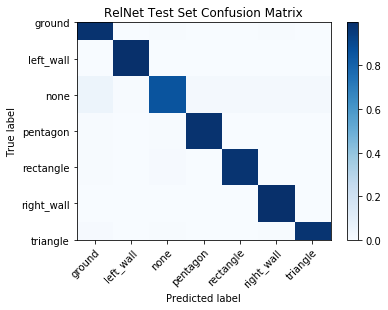

In [26]:
# sample new test set
states_test,targets_test,envs_test, idx2col, col2idx = createStates(df_ball, df_env, df_col,device)

savename = repo_path + '/experiments/collisions/relnet1_9000epochs'

model = relNet(state_size = 4, state_hn = 4, state_embed_size=32,
                obj_size = 3, obj_hn = 4,obj_embed_size=16,
                obj_n = 3, nullobj_n = 4,
                mlp_hsize = 16, mlp_hn=3, mlp_outsize=1).to(device)
model.load_state_dict(torch.load(savename + '.model'))
model.eval()
outputs = model(envs_test, states_test)

cm = confusion_matrix(targets_test.cpu(), outputs.argmax(-1).cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize
classes = idx2col
print(classes)

print(cm)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='RelNet Test Set Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

s = 'relnet1_9000epochs_testconfusion'
path = repo_path + '/experiments/collisions/'
plt.savefig(path+s)